In [1]:
import sys
import os
import math
import copy
import time

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from sklearn.metrics import roc_auc_score
from scipy import fft
from data_loader import LoadDataset

from classifier import classifier

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
class EnergyError(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [3]:
ds_path = "/home/rauf/workspace/data/ESC-50"
batch_size = 5
esc_10 = False
if esc_10:
    n_classes = 10
else:
    n_classes = 50
trainloader = LoadDataset(ds_path, "train")
dataloader_train = torch.utils.data.DataLoader(trainloader, batch_size,
                             shuffle=True,
                             pin_memory=False)

eval_loader = LoadDataset(ds_path, "test")
dataloader_eval = torch.utils.data.DataLoader(eval_loader, batch_size,
                             shuffle=True,
                             pin_memory=False)

In [4]:
net = classifier(5,8, n_classes)
net.cuda()
best_score = float("inf")

In [5]:
name = 'ESC50'
writer = SummaryWriter('runs/' + name)

In [6]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.98)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor=0.7, patience=4, verbose=True, threshold=0.0001)

epoch = 0, iter = 0, energy = 3.169, CE_Loss = 4.382, Loss = 5.195, Acc = 1.0


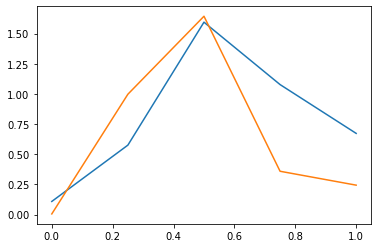

Val Loss = 5.084, Val Acc = 1.0
epoch = 0, iter = 100, energy = 0.4477, CE_Loss = 0.0, Loss = 1.296, Acc = 1.0


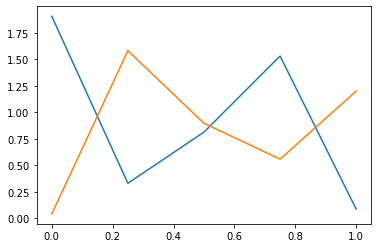

epoch = 0, iter = 200, energy = 0.05056, CE_Loss = 0.0, Loss = 0.991, Acc = 1.0


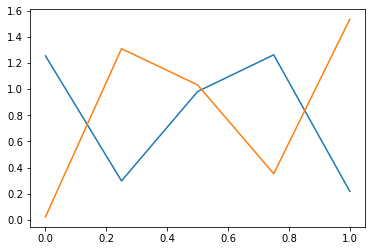

Val Loss = 0.9866, Val Acc = 1.0
epoch = 0, iter = 300, energy = 0.005266, CE_Loss = 0.0001057, Loss = 0.59, Acc = 1.0


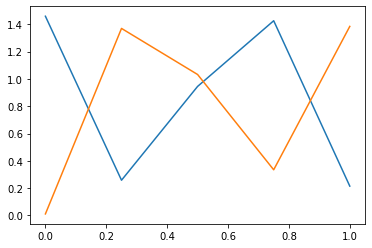

epoch = 1, iter = 0, energy = 0.003957, CE_Loss = 0.005534, Loss = 0.5335, Acc = 1.0


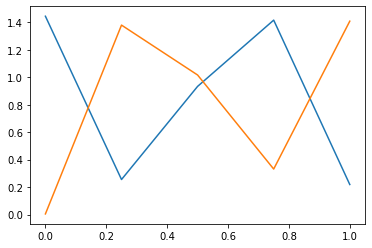

Val Loss = 0.5309, Val Acc = 1.0
epoch = 1, iter = 100, energy = 0.001249, CE_Loss = 0.01096, Loss = 0.394, Acc = 1.0


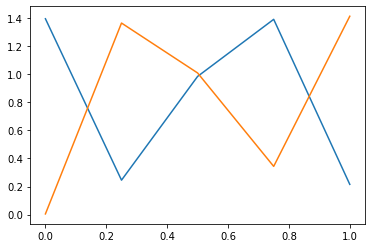

epoch = 1, iter = 200, energy = 0.0006251, CE_Loss = 0.02324, Loss = 0.3391, Acc = 1.0


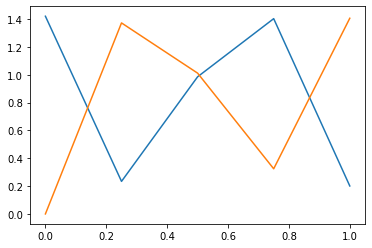

Val Loss = 0.3386, Val Acc = 1.0


In [ ]:
C = 0.04
lambda_reg = 0.04

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

for epoch in range(100):  # loop over the dataset multiple times 
    for i, (inputs, labels) in enumerate(dataloader_train):
        # get the inputs
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        
               

        _, labels = torch.max(labels, 1)
        
        

        acc = (outputs.max(1)[1]==labels).float().mean() 
        
        loss, en, ce_loss = net.criterion(outputs, labels, net.wavelet.hi, net.wavelet.lo, C,lambda_reg)
        
        writer.add_scalar("loss", loss.item())
        writer.add_scalar("Regularisation", en.item())
        writer.add_scalar("Acc", acc.item())
        
        try:
            if en > 50: raise EnergyError(en)
        except EnergyError as e:
#             net = classifier(5,8,Y.shape[1])
#             net.load_state_dict(torch.load('saves/best' + name))
#             net.cuda()
#             net.wavelet.reset_weights_enc()
#             C= C*0.7
#             optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']*0.7
#             print ('Energy of filteres occurred to be:', e.value, ce_loss, ' step is ', i, optimizer.param_groups[0]['lr'],C)
#             continue
            raise KeyboardInterrupt
            

        loss.backward()
        optimizer.step()
        

        if i%100 == 0:
            
            print ('epoch = {}, iter = {}, energy = {:1.4}, CE_Loss = {:1.4}, Loss = {:1.4}, Acc = {:1.4}'.format
                   (epoch, i, en.item(), ce_loss.item(), loss.item(), acc.item()))
                
            idx = torch.arange(net.wavelet.hi.size(2)-1, -1, -1).long()
            hi_f = np.abs(fft(net.wavelet.hi[0,0,idx].cpu().data.numpy()))
            lo_f = np.abs(fft(net.wavelet.lo[0,0,idx].cpu().data.numpy()))
            n = hi_f.shape[-1]
            plt.plot(np.arange(n//2+1)/(n//2),lo_f[:n//2+1]) 
            plt.plot(np.arange(n//2+1)/(n//2),hi_f[:n//2+1]) 
            plt.show()
                
        if i%200 == 0:
            inputs, labels = next(iter(dataloader_eval))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            loss, _,_ = net.criterion(outputs, labels, net.wavelet.hi, net.wavelet.lo, C,lambda_reg)
            scheduler.step(loss)
            acc = (outputs.max(1)[1]==labels).float().mean() 
            
            print ('Val Loss = {:1.4}, Val Acc = {:1.4}'.format(loss.item(), acc.item()))
            if best_score > loss.item():
                best_score = loss.item()
                torch.save(net.state_dict(),'saves/best' + name)
            else:
                torch.save(net.state_dict(),'saves/latest_model')
                
           
            writer.add_scalar("Val loss", loss.item()) 
            writer.add_scalar("Val acc", acc.item())     

In [ ]:
Y.shape

In [22]:
net = classifier(5,8,Y.shape[1])
net.load_state_dict(torch.load('saves/latest_model' + name))
net.cuda()
# net.wavelet.reset_weights_enc()

classifier(
  (wavelet): Wavelet()
  (conv1): Conv1d(6, 10, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(10, 15, kernel_size=(3,), stride=(1,))
  (lastpool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=15, out_features=120, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=120, out_features=7, bias=True)
)

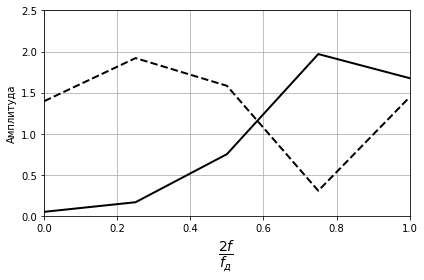

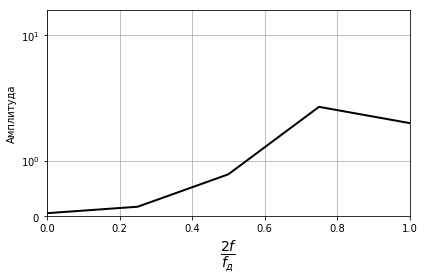

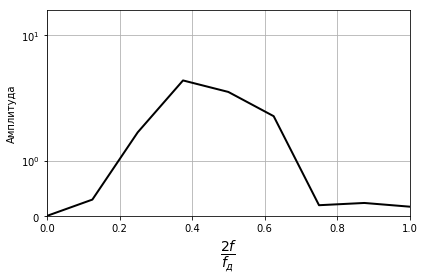

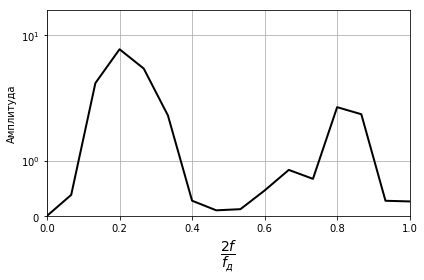

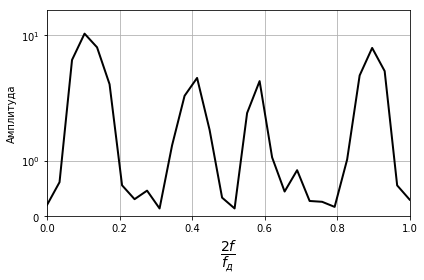

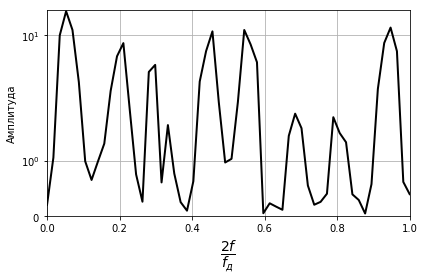

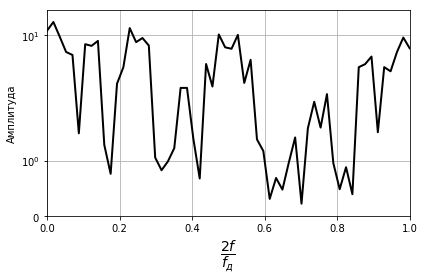

In [41]:
''' Plot and save fft of filters at corrent dir'''

hi,lo = net.wavelet.weight_hi, net.wavelet.weight_lo 

idx = torch.arange(hi.size(2)-1, -1, -1).long() 
hi_f,lo_f = np.abs(fft(hi[0,0,idx].cpu().data.numpy())), np.abs(fft(lo[0,0,idx].cpu().data.numpy())) 
n = hi_f.shape[-1] 
plt.grid(True) 
plt.tight_layout()
plt.axis([0, 1, 0, 2.5])  
plt.plot(np.arange(n//2+1)/(n//2),lo_f[:n//2+1], 'k--',lw=2) 
plt.plot(np.arange(n//2+1)/(n//2),hi_f[:n//2+1], 'k', lw=2) 
plt.xlabel(r'$\frac{2f}{f_д}$', fontsize=20) 
plt.ylabel('Амплитуда') 
plt.tight_layout()
plt.savefig('High_b.png', dpi=100) 
plt.show() 
for i,w in enumerate(net.wavelet.weights): 
    plt.grid(True) 
    idx = torch.arange(w.size(2)-1, -1, -1).long() 
    f = np.abs(fft(w[0,0,idx].cpu().data.numpy())) 
    n = w.shape[-1] 
    plt.axis([0, 1, 0, 18])
    plt.yscale("symlog")
    plt.xlabel(r'$\frac{2f}{f_д}$', fontsize=20) 
    plt.ylabel('Амплитуда') 
    plt.plot(np.array(range(n//2+1))/(n//2),f[:n//2+1], 'k', lw=2) 
    plt.tight_layout()
    plt.savefig('high_b{}.png'.format(i)) 
    plt.show()

In [8]:
from IPython.display import clear_output

total = 0
correct = 0
test_gen = ESC50(folds=[test_split],
                 randomize=False,
                 strongAugment=False,
                 random_crop=False,
                 inputLength=4,
                 **shared_params).batch_gen(50)


for inputs, labels in test_gen:
        # get the inputs
        inputs, labels = torch.Tensor(inputs).transpose(1,2).cuda(), torch.LongTensor(labels).cuda()

        # forward + backward + optimize
        outputs = net(inputs)

        _, predicted = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        
#         loss = criterion(outputs, labels, net.wavelet.weight_hi, net.wavelet.weight_lo, C, l2)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        clear_output(wait=1)
        print('Accuracy of the network on the 10000 test images: %f' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 14.210526


KeyboardInterrupt: 

In [18]:
from graphviz import render, make_dot_from_trace

In [1]:
d = make_dot(net(inputs), params=dict(net.named_parameters()))
d.render(format='png')

NameError: name 'make_dot' is not defined